In [4]:
%pip install networkx
%pip install matplotlib
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
df = pd.read_excel('data/aml_sample.xlsx')
df.head()

,transaction_id,timestamp,source_account,target_account,amount,currency,payment_type,is_laundering
0,fba2c697-af5,2025-01-30 05:37:52,d22edd47-d62,2c16ef74-e2a,1544.96,CHF,check,False
1,99b3a5de-fcc,2025-01-04 22:22:27,3186a560-822,2c16ef74-e2a,3570.94,CHF,check,False
2,584747eb-232,2025-01-20 08:12:38,394327a7-4f8,11465b45-fa7,197.05,EUR,wire,False
3,18f0f15b-35f,2025-01-25 12:20:57,96cceac8-2a9,234f5826-a28,160.86,EUR,credit_card,False
4,3038ba38-edb,2025-01-04 03:47:42,e00c8c30-37e,85e3613e-fd4,4292.82,USD,credit_card,False


In [8]:
G = nx.DiGraph()

for _, row in df.iterrows():
    src = row['source_account']
    tgt = row['target_account']
    amt = row['amount']
    laundering = row['is_laundering']
    G.add_edge(src, tgt, amount=amt, money_laundering=laundering)

In [14]:
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")

laundering_edges = sum(1 for _, _, d in G.edges(data=True) if d.get('money_laundering', False))

print(f"Laundering transactions: {laundering_edges}")


Total nodes: 50
Total edges: 834
Laundering transactions: 35


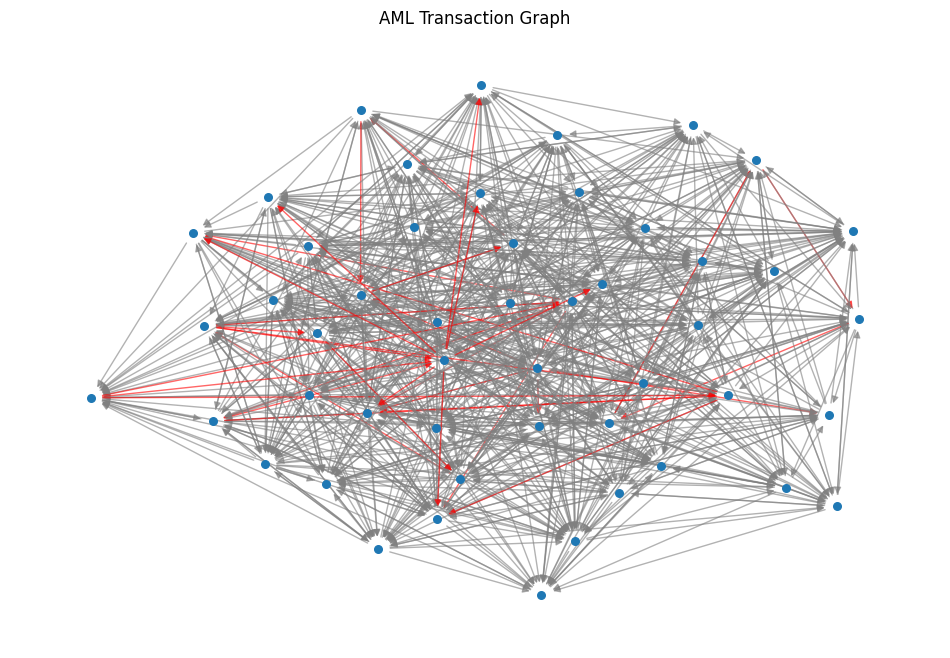

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Use spring layout for basic visualization
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Color laundering edges red
edge_colors = ['red' if d['money_laundering'] else 'gray' for _, _, d in G.edges(data=True)]

nx.draw_networkx_nodes(G, pos, node_size=30)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=True, alpha=0.6)
plt.title("AML Transaction Graph")
plt.axis('off')
plt.show()


In [19]:
# Step 1: Extract laundering edges only
laundering_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('money_laundering', False)]

# Step 2: Create a subgraph with those edges
G_laundering = G.edge_subgraph(laundering_edges).copy()

print(f"Laundering subgraph — Nodes: {G_laundering.number_of_nodes()}, Edges: {G_laundering.number_of_edges()}")


Laundering subgraph — Nodes: 24, Edges: 35


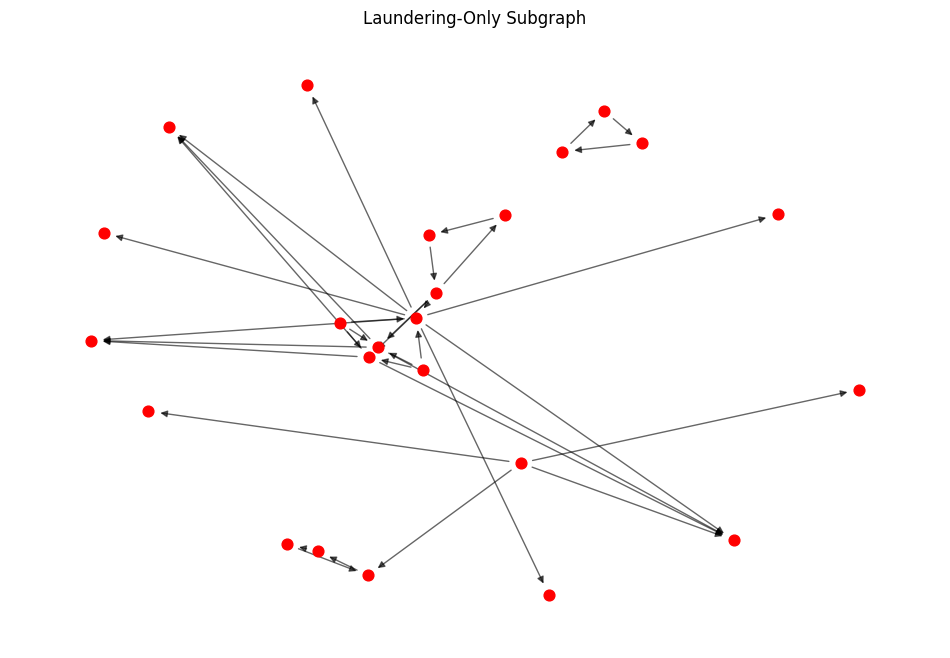

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_laundering, k=0.4)

nx.draw_networkx_nodes(G_laundering, pos, node_color='red', node_size=60)
nx.draw_networkx_edges(G_laundering, pos, edge_color='black', arrows=True, alpha=0.6)

plt.title("Laundering-Only Subgraph")
plt.axis('off')
plt.show()


In [32]:
from collections import defaultdict
import networkx as nx

# Step 1: Aggregate laundering transactions by (source, target)
edge_aggregates = defaultdict(lambda: {"amount": 0, "laundering": False})

for _, row in df[df["is_laundering"] == True].iterrows():
    key = (row["source_account"], row["target_account"])
    edge_aggregates[key]["amount"] += row["amount"]
    edge_aggregates[key]["laundering"] = True  # All transactions are laundering here

# Step 2: Build weighted graph
G_laundering_weighted = nx.DiGraph()

for (src, tgt), attrs in edge_aggregates.items():
    G_laundering_weighted.add_edge(
        src, tgt,
        weight=attrs["amount"],
        is_laundering=attrs["laundering"]
    )


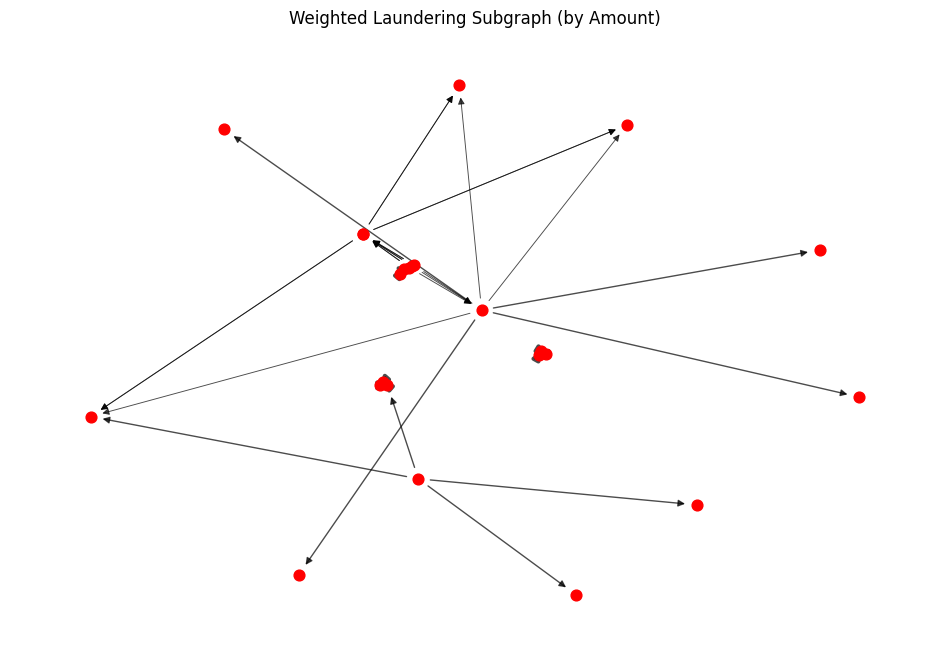

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_laundering_weighted, k=0.4)

# Scale edge width by weight
weights = [d['weight'] / 500 for _, _, d in G_laundering_weighted.edges(data=True)]  # adjust divisor to scale nicely

nx.draw_networkx_nodes(G_laundering_weighted, pos, node_color='red', node_size=60)
nx.draw_networkx_edges(
    G_laundering_weighted, pos,
    width=weights,
    edge_color='black',
    arrows=True,
    alpha=0.7
)

plt.title("Weighted Laundering Subgraph (by Amount)")
plt.axis('off')
plt.show()


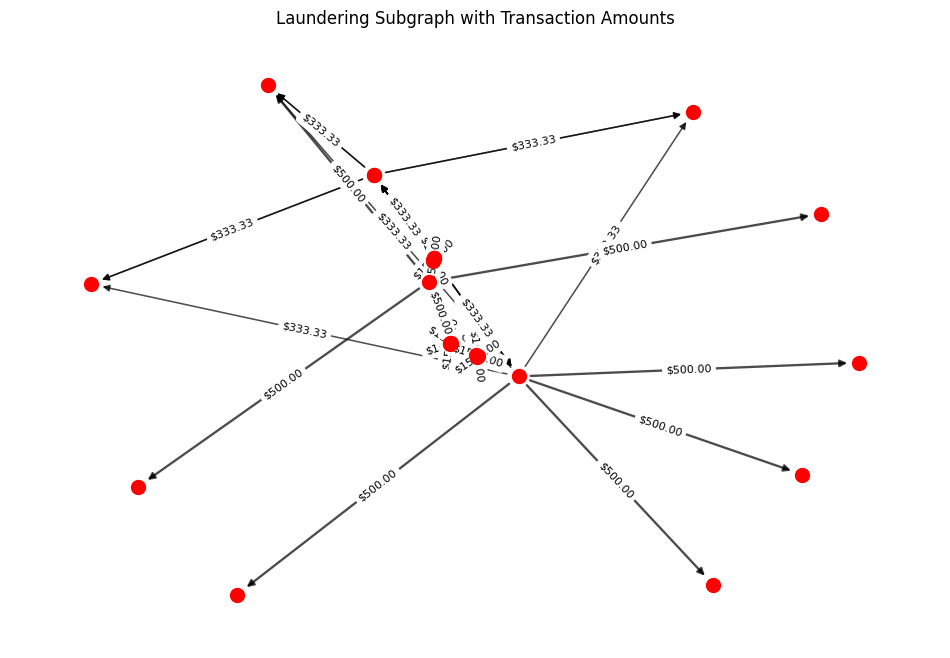

In [29]:
import matplotlib.pyplot as plt

# Adjust layout for better spacing
pos = nx.spring_layout(G_laundering_weighted, k=0.2, iterations=100)

# Draw nodes and weighted edges
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_laundering_weighted, pos, node_color='red', node_size=100)

# Scale edge width by weight with a better scaling factor
max_weight = max(d['weight'] for _, _, d in G_laundering_weighted.edges(data=True))
edge_weights = [d['weight'] / max_weight * 5 for _, _, d in G_laundering_weighted.edges(data=True)]
nx.draw_networkx_edges(
    G_laundering_weighted,
    pos,
    width=edge_weights,
    edge_color='black',
    alpha=0.7,
    arrows=True
)

# ✅ Draw edge labels with total amount
edge_labels = {
    (u, v): f"${d['weight']:.2f}"
    for u, v, d in G_laundering_weighted.edges(data=True)
}
nx.draw_networkx_edge_labels(G_laundering_weighted, pos, edge_labels=edge_labels, font_size=8)

plt.title("Laundering Subgraph with Transaction Amounts")
plt.axis('off')
plt.show()
